In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import parallel_where, Aligner4

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
available_label_indices = sorted(labels_sided_indices.values())

In [ ]:
# available_label_indices = [i for i in np.unique(atlas_volume) if i > 0]

In [3]:
labelIndexMap_sidedToUnsided = {i: labels_unsided_indices[labelMap_sidedToUnsided[labels_sided[i-1]]] 
                                for i in available_label_indices}

In [4]:
labelIndexMap_m2f = {labels_sided_indices[name_s]: labels_unsided_indices[name_u] 
                        for name_s, name_u in labelMap_sidedToUnsided.iteritems() \
                        if name_s in [labels_sided[i-1] for i in available_label_indices]}
print labelIndexMap_m2f

{1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 4, 7: 4, 8: 5, 9: 5, 10: 6, 11: 7, 12: 7, 13: 8, 14: 8, 15: 9, 16: 9, 17: 10, 18: 10, 19: 11, 20: 11, 21: 12, 22: 13, 23: 13, 24: 14, 25: 14, 26: 15, 27: 16}


In [5]:
stack = 'MD589'

In [6]:
subject_volume_allLabels = {}

for ind_f in set(labelIndexMap_sidedToUnsided.values()):
    print ind_f

    subject_volume_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                      {'stack': stack, 'label': labels_unsided[ind_f-1]})).astype(np.float16)
    subject_volume_allLabels[ind_f] = subject_volume_roi
    del subject_volume_roi

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [7]:
gradient_filepath_map_f = {ind_f: volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_%%(suffix)s.bp' % \
                           {'stack': stack, 'label': labels_unsided[ind_f-1]}
                           for ind_f in set(labelIndexMap_sidedToUnsided.values())}

In [ ]:
# T, scores = align(volume_f=subject_volume_allLabels, 
#                   volume_m=atlas_volume, 
#                   type='rigid',
# #                   centroid_m='structure_centroid',
#                   centroid_m='volume_centroid',
# #                   centroid_f='centroid_m',
#                   centroid_f='volume_centroid',
#                   labelIndexMap_m2f=labelIndexMap_m2f,
#                   gradient_filepath_map_f=gradient_filepath_map_f,
#                   grid_search_iteration_number=3, max_iter_num=100, history_len=200, terminate_thresh=.1)

In [ ]:
# individual

atlas_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack': stack}))

In [ ]:
all_indices_m = list(set(labelIndexMap_m2f.keys()) & set(np.unique(atlas_volume)))

In [ ]:
nzvoxels_m = Parallel(n_jobs=16)(delayed(parallel_where)(atlas_volume, i, num_samples=int(1e5))
                                 for i in all_indices_m)
nzvoxels_m = dict(zip(all_indices_m, nzvoxels_m))

In [ ]:
aligner = Aligner(volume_f=subject_volume_allLabels, volume_m=atlas_volume, 
                  nzvoxels_m=nzvoxels_m,
                  labelIndexMap_m2f=labelIndexMap_m2f)

In [ ]:
aligner.set_centroid(centroid_m='structure_centroid',
                     centroid_f='centroid_m',
                    indices_m=[labels_sided_indices['12N']])

In [ ]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=[labels_unsided_indices['12N']])

In [ ]:
# T, scores = aligner.optimize(type='rigid', init_T=T0, max_iter_num=100, history_len=200, terminate_thresh=.1)
# T, scores = aligner.optimize(type='rigid', grid_search_iteration_number=3, max_iter_num=100, history_len=200, terminate_thresh=.1)
T, scores = aligner.optimize(type='rigid', max_iter_num=100, history_len=500, terminate_thresh=1e-4,
                             indices_m=[labels_sided_indices['12N']])

In [ ]:
print T.reshape((3,4))
plt.plot(scores);

In [ ]:
aligner.compute_score(T.flatten(), indices_m=[labels_sided_indices['7n_L']])

In [ ]:
aligner.compute_score(T.flatten(), indices_m=all_indices_m)

In [ ]:
aligner.compute_hessian()

In [ ]:
del aligner

In [ ]:
from collections import defaultdict

In [ ]:
results = defaultdict(dict)

In [ ]:
# global 

In [8]:
# atlas_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, 'MD589/volume_MD589_annotation_withOuterContour.bp'))
atlas_volume = bp.unpack_ndarray_file(volume_dir + '/atlasVolume_icp.bp')

In [9]:
all_indices_m = list(set(labelIndexMap_m2f.keys()) & set(np.unique(atlas_volume)))

In [10]:
nzvoxels_m = Parallel(n_jobs=16)(delayed(parallel_where)(atlas_volume, i, num_samples=int(1e5))
                                 for i in all_indices_m)
nzvoxels_m = dict(zip(all_indices_m, nzvoxels_m))

In [11]:
aligner = Aligner2(volume_f_=subject_volume_allLabels, volume_m_=atlas_volume, 
                  nzvoxels_m_=nzvoxels_m,
                  labelIndexMap_m2f=labelIndexMap_m2f)

In [ ]:
# aligner = Aligner(volume_f=subject_volume_allLabels, volume_m=atlas_volume, 
#                   nzvoxels_m=nzvoxels_m,
#                   labelIndexMap_m2f=labelIndexMap_m2f)

In [12]:
aligner.set_centroid(centroid_m='volume_centroid',
                     centroid_f='volume_centroid')

In [13]:
names_sided_considered = ['7N_R', '7n_L']
indices_sided_considered = [labels_sided_indices[name_s] for name_s in names_sided_considered]
indices_unsided_considered = set([labels_unsided_indices[labelMap_sidedToUnsided[name_s]] 
                                  for name_s in names_sided_considered])

In [14]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=indices_unsided_considered)

load gradient 4: 5.469819 seconds
load gradient 5: 5.006631 seconds
overall: 10.477239 seconds


In [15]:
T, scores = aligner.optimize(type='rigid', grid_search_iteration_number=3,
                             max_iter_num=5000, history_len=200, terminate_thresh=1e-3,
                            indices_m=indices_sided_considered)

grid search: 1.685704 seconds
grid search: 1.299966 seconds
grid search: 1.019692 seconds


In [25]:
from itertools import combinations

In [34]:
trial_combinations = map(frozenset, list(combinations([name_s for name_s in labels_sided if name_s != 'sp5' and name_s != 'outerContour'], 3)))
print len(trial_combinations)

2300


[[  9.96139858e-01   8.74488651e-02  -7.62100901e-03  -8.67785961e+01]
 [ -8.77782593e-02   9.92949512e-01  -7.96633113e-02   3.74900907e+01]
 [  6.00811017e-04   8.00247585e-02   9.96792695e-01  -1.48087120e+00]]


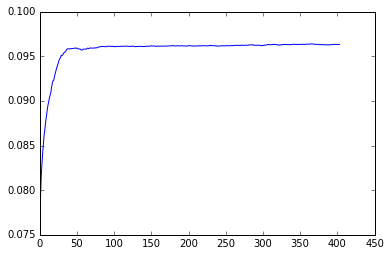

In [16]:
print T.reshape((3,4))
plt.plot(scores);

In [17]:
aligner.compute_score(T.flatten())

0.75514953464517021

In [ ]:
aligner.compute_score(T.flatten(), indices_m=[labels_sided_indices['7N_L']])

In [18]:
t = time.time()
H = aligner.compute_hessian(T, step=np.r_[1e-1, 1e-1, 1e-1, 10,
                                      1e-1, 1e-1, 1e-1, 10,
                                      1e-1, 1e-1, 1e-1, 10])
sys.stderr.write('Compute hessian: %f seconds\n' % (time.time() - t))

# when n = 1000, std is very stable; when n = 100, variation is +/- 0.1
nbr_scores = aligner.compute_scores_neighborhood_random(T.flatten(), n=1000, stds=[0,0,0,10,0,0,0,10,0,0,0,10])
nbr_std = np.std(nbr_scores)

Compute hessian: 47.843505 seconds


In [21]:
results[stack][frozenset(names_sided_considered)] = (T, scores, H, nbr_std)

NameError: name 'results' is not defined

In [ ]:
U, S, VT = np.linalg.svd(H[np.r_[3,7,11], np.r_[3,7,11][:,None]])
z_principle = 1./2. * 10**2 * -S / nbr_std
print z_principle

In [ ]:
results.default_factory = None